<a href="https://colab.research.google.com/github/ankitamolak21/Mini-Project-/blob/main/Copy_of_Violence_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Dataset

In [ ]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

/bin/bash: line 1: nvidia-smi: command not found
Tensorflow version 2.15.0


In [ ]:
!pip install numpy pandas jovian opendatasets scikit-learn xgboost --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset/download?datasetVersionNumber=1'

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./real-life-violence-situations-dataset" (use force=True to force download)


In [ ]:
data_dir ='/content/real-life-violence-situations-dataset'

# Importing Required Libraries

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<ipython-input-8-03591f026cbc>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Data Visualization

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
# Classes Directories
NonViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

# Frame Extraction

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16


DATASET_DIR = "/content/real-life-violence-situations-dataset/real life violence situations/Real Life Violence Dataset"

CLASSES_LIST = ["NonViolence","Violence"]

In [ ]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Limit to 550 videos per category
        files_list = files_list[:550]

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [ ]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# Encoding and Splitting Training-Testing Dataset

In [ ]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(990, 16, 64, 64, 3) (990, 2)
(110, 16, 64, 64, 3) (110, 2)


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

In [ ]:
def create_model():

    model = Sequential()

    ########################################################################################################################

    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))


    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    model.summary()

    return model

In [ ]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
#plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/20
99/99 [==============================] - 142s 1s/step - loss: 0.6929 - accuracy: 0.5518 - val_loss: 0.6863 - val_accuracy: 0.5960 - lr: 0.0100
Epoch 2/20
99/99 [==============================] - 131s 1s/step - loss: 0.6887 - accuracy: 0.5556 - val_loss: 0.6737 - val_accuracy: 0.6061 - lr: 0.0100
Epoch 3/20
99/99 [==============================] - 143s 1s/step - loss: 0.6844 - accuracy: 0.5543 - val_loss: 0.6610 - val_accuracy: 0.6263 - lr: 0.0100
Epoch 4/20
99/99 [==============================] - 131s 1s/step - loss: 0.6380 - accuracy: 0.6465 - val_loss: 0.5889 - val_accuracy: 0.7323 - lr: 0.0100
Epoch 5/20
99/99 [==============================] - 145s 1s/step - loss: 0.5174 - accuracy: 0.7727 - val_loss: 0.5096 - val_accuracy: 0.7273 - lr: 0.0100
Epoch 6/20
99/99 [==============================] - 131s 1s/step - loss: 0.4561 - accuracy: 0.8106 - val_loss: 0.4759 - val_accuracy: 0.7828 - lr: 0.0100
Epoch 7/20
99/99 [==============================] - 130s 1s/step - loss: 0.3

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/20
99/99 [==============================] - 161s 2s/step - loss: 0.0871 - accuracy: 0.9684 - val_loss: 1.1072 - val_accuracy: 0.7424 - lr: 0.0100
Epoch 2/20
99/99 [==============================] - 143s 1s/step - loss: 0.1557 - accuracy: 0.9583 - val_loss: 0.5025 - val_accuracy: 0.8434 - lr: 0.0100
Epoch 3/20
99/99 [==============================] - 141s 1s/step - loss: 0.1036 - accuracy: 0.9684 - val_loss: 0.4969 - val_accuracy: 0.8535 - lr: 0.0100
Epoch 4/20
99/99 [==============================] - 131s 1s/step - loss: 0.1001 - accuracy: 0.9697 - val_loss: 0.6751 - val_accuracy: 0.8182 - lr: 0.0100
Epoch 5/20
99/99 [==============================] - 131s 1s/step - loss: 0.0554 - accuracy: 0.9874 - val_loss: 0.5092 - val_accuracy: 0.8636 - lr: 0.0100
Epoch 6/20
99/99 [==============================] - 137s 1s/step - loss: 0.0445 - accuracy: 0.9861 - val_loss: 0.5319 - val_accuracy: 0.8737 - lr: 0.0100
Epoch 7/20
99/99 [==============================] - 131s 1s/step - loss: 0.0

In [ ]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

4/4 [==============================] - 11s 2s/step - loss: 0.4750 - accuracy: 0.8818


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

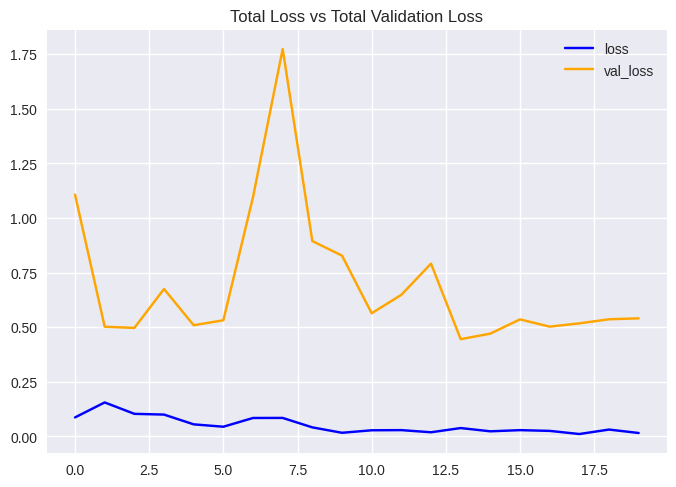

In [ ]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

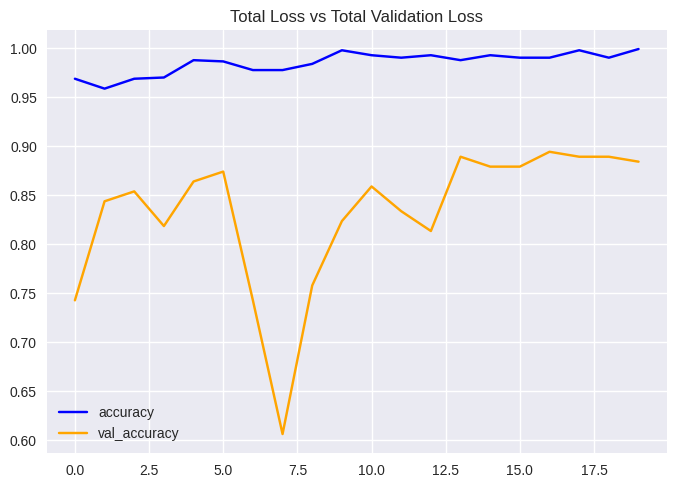

In [ ]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')


In [ ]:
labels_predict = MoBiLSTM_model.predict(features_test)

4/4 [==============================] - 15s 2s/step


In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

((110,), (110,))

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8818181818181818


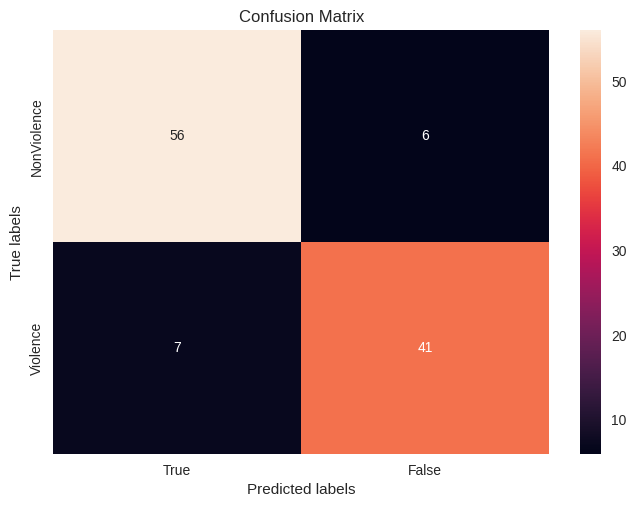

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90        62
           1       0.87      0.85      0.86        48

    accuracy                           0.88       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110



In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_450.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 152ms/step
Predicted: NonViolence
Confidence: 0.999961256980896


In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_650.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 170ms/step
Predicted: Violence
Confidence: 0.9996439218521118


In [ ]:
import pickle

In [ ]:
# prompt: write code to save the trained model using pickle

import pickle

# Save the model to a file
with open('MobBiLSTM_model.pkl', 'wb') as f:
  pickle.dump(MoBiLSTM_model, f)

# Load the model from the file
with open('MobBiLSTM_model.pkl', 'rb') as f:
  model = pickle.load(f)


In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_570.mp4"
# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 145ms/step
Predicted: NonViolence
Confidence: 0.9997209906578064
